In [9]:
!pip install pyspark


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

# Initialize the spark session
spark = SparkSession.builder.appName("HealthcareAnalysis").getOrCreate()

25/03/02 16:01:41 WARN Utils: Your hostname, Hanss-Lenovo-Yoga-3.local resolves to a loopback address: 127.0.0.1; using 192.168.101.242 instead (on interface en0)
25/03/02 16:01:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/02 16:01:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [11]:
admissions_df = spark.read.csv(
    "./dataset/HDHI_Admission_data.csv", header=True, inferSchema=True)
mortality_df = spark.read.csv(
    "./dataset/HDHI_Mortality_Data.csv", header=True, inferSchema=True)
pollution_df = spark.read.csv(
    "./dataset/HDHI_Pollution_Data.csv", header=True, inferSchema=True)

In [12]:
# Register DataFrames as temporary views
admissions_df.createOrReplaceTempView("admissions")
mortality_df.createOrReplaceTempView("mortality")
pollution_df.createOrReplaceTempView("pollution")

# Query 1: Analyze admission trends by age group and gender
age_gender_analysis = spark.sql("""
    SELECT 
        CASE 
            WHEN AGE < 18 THEN 'Child'
            WHEN AGE BETWEEN 18 AND 35 THEN 'Young Adult'
            WHEN AGE BETWEEN 36 AND 55 THEN 'Adult'
            ELSE 'Senior'
        END AS age_group,
        GENDER,
        COUNT(*) as admission_count
    FROM admissions
    GROUP BY 1, 2
    ORDER BY 1, 2
""")

# Query 2: Analyze correlation between pollution levels and mortality
pollution_mortality = spark.sql("""
    SELECT 
        p.DATE,
        p.AQI,
        p.PM2_5_AVG,
        COUNT(m.MRD) as mortality_count
    FROM pollution p
    LEFT JOIN mortality m ON p.DATE = m.`DATE OF BROUGHT DEAD`
    GROUP BY 1, 2, 3
    ORDER BY 1
""")

# Query 3: Analyze common comorbidities
comorbidities = spark.sql("""
    SELECT 
        SUM(CASE WHEN DM = 1 THEN 1 ELSE 0 END) as diabetes_count,
        SUM(CASE WHEN HTN = 1 THEN 1 ELSE 0 END) as hypertension_count,
        SUM(CASE WHEN CAD = 1 THEN 1 ELSE 0 END) as cad_count,
        SUM(CASE WHEN CKD = 1 THEN 1 ELSE 0 END) as ckd_count,
        COUNT(*) as total_admissions
    FROM admissions
""")

25/03/02 16:01:45 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [20]:
comorbidity_results = comorbidities.collect()[0]

In [21]:
total_admissions = comorbidity_results['total_admissions']
diabetes_prevalence = comorbidity_results['diabetes_count'] / \
    total_admissions * 100
hypertension_prevalence = comorbidity_results['hypertension_count'] / \
    total_admissions * 100
cad_prevalence = comorbidity_results['cad_count'] / total_admissions * 100
ckd_prevalence = comorbidity_results['ckd_count'] / total_admissions * 100

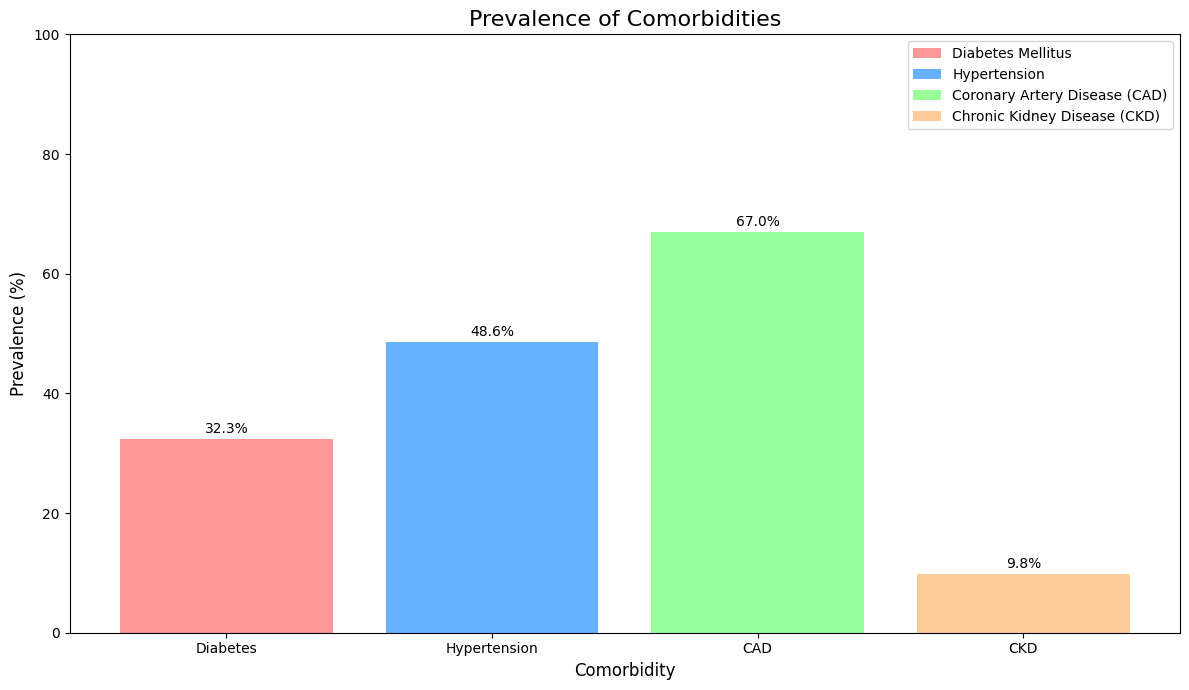

In [23]:
import matplotlib.pyplot as plt

comorbidities = ['Diabetes', 'Hypertension', 'CAD', 'CKD']
prevalences = [diabetes_prevalence,
               hypertension_prevalence, cad_prevalence, ckd_prevalence]
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

plt.figure(figsize=(12, 7))
bars = plt.bar(comorbidities, prevalences, color=colors)
plt.title('Prevalence of Comorbidities', fontsize=16)
plt.xlabel('Comorbidity', fontsize=12)
plt.ylabel('Prevalence (%)', fontsize=12)
plt.ylim(0, 100)

for i, v in enumerate(prevalences):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

plt.legend(bars, ['Diabetes Mellitus', 'Hypertension',
                  'Coronary Artery Disease (CAD)',
                  'Chronic Kidney Disease (CKD)'],
           loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

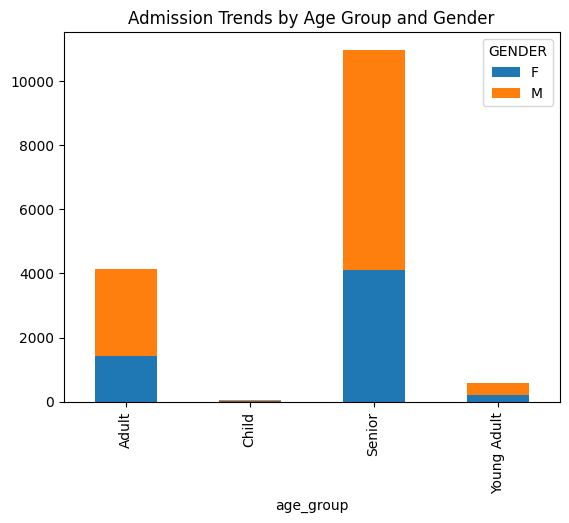

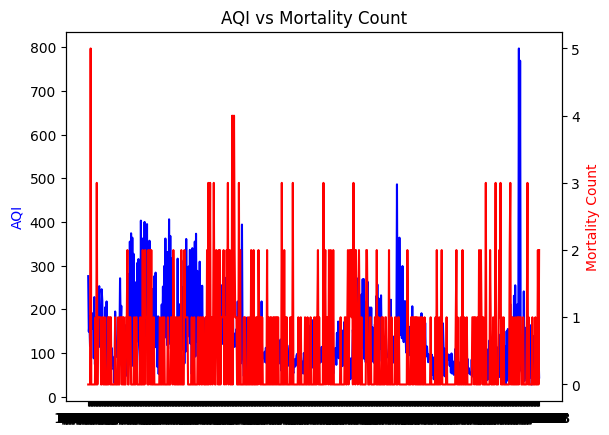

In [13]:
import matplotlib.pyplot as plt

# Visualize admission trends
age_gender_data = age_gender_analysis.toPandas()
age_gender_data.pivot(index='age_group', columns='GENDER',
                      values='admission_count').plot(kind='bar', stacked=True)
plt.title('Admission Trends by Age Group and Gender')
plt.show()

# Visualize pollution and mortality correlation
pollution_mortality_data = pollution_mortality.toPandas()
fig, ax1 = plt.subplots()
ax1.plot(pollution_mortality_data['DATE'],
         pollution_mortality_data['AQI'], color='blue')
ax1.set_ylabel('AQI', color='blue')
ax2 = ax1.twinx()
ax2.plot(pollution_mortality_data['DATE'],
         pollution_mortality_data['mortality_count'], color='red')
ax2.set_ylabel('Mortality Count', color='red')
plt.title('AQI vs Mortality Count')
plt.show()

# Visualize the commordibities
comorbidities_data = comorbidities.toPandas()


In [14]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [15]:
# Prepare data for mortality prediction
ml_data = admissions_df.select(
    col("AGE"), col("GENDER"), col("DM"), col("HTN"), col("CAD"), col("CKD"),
    (col("OUTCOME") == "EXPIRY").cast("int").alias("mortality")
)
ml_data.printSchema()

root
 |-- AGE: integer (nullable = true)
 |-- GENDER: string (nullable = true)
 |-- DM: integer (nullable = true)
 |-- HTN: integer (nullable = true)
 |-- CAD: integer (nullable = true)
 |-- CKD: integer (nullable = true)
 |-- mortality: integer (nullable = true)



25/03/02 16:01:54 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [16]:
from pyspark.ml.feature import StringIndexer

# Convert GENDER to numeric
gender_indexer = StringIndexer(inputCol="GENDER", outputCol="GENDER_INDEX")
ml_data = gender_indexer.fit(ml_data).transform(ml_data)

In [17]:
from pyspark.ml.feature import VectorAssembler

# Create feature vector
assembler = VectorAssembler(
    inputCols=["AGE", "GENDER_INDEX", "DM", "HTN", "CAD", "CKD"],
    outputCol="features"
)
ml_data = assembler.transform(ml_data)

In [18]:
from pyspark.sql.functions import col

ml_data = ml_data.withColumn("DM", col("DM").cast("double"))
ml_data = ml_data.withColumn("HTN", col("HTN").cast("double"))
ml_data = ml_data.withColumn("CAD", col("CAD").cast("double"))
ml_data = ml_data.withColumn("CKD", col("CKD").cast("double"))

In [19]:
# Split data
train_data, test_data = ml_data.randomSplit([0.7, 0.3], seed=42)

# Train Random Forest model
rf = RandomForestClassifier(
    labelCol="mortality", featuresCol="features", numTrees=10)
model = rf.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate model
evaluator = BinaryClassificationEvaluator(labelCol="mortality")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

AUC: 0.7057862552706781
